In [ ]:
!pip install opencv-python
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install pillow
!pip install torchvision

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.6 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.6 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.8/204.1 MB 4.8 MB/s eta 0:00:43
   ---------------------------------------- 2.1/204.1 MB 5.9 MB/s eta 0:00:35
    --------------------------------------- 3.4/204.1 MB 5.8 MB/s eta 0:00:35
    --------------------------------------- 4.5/204.1 MB 6.0 MB/s eta 0:00:34
    --------------------------------------- 4.7/204.1 MB 4.8 MB/s eta 0:00:42
   - -------------------------------------- 6.0/204.1 MB 5.4 MB/s eta 0:00:37
   - -------------------------------------- 7.1/204.1 MB 4.9 MB/s eta 0:00:41
   - -------------------------------------- 8.1/204.1 MB 5.1 MB/s eta 0:00:39
   -- ---------

# Resizing the images:
Why resizing?
Origional images resolution might be very large, sometimes 1024x 1024. This might lead to high memory usage and longer computations.
Ideally, we can use varying sized images if we can spend high computation power and willing to adjust the architecture of CNN, adapting to different images.Sometimes, decreasing the resolution also helps from overfitting.
224X224 image size provides a good balance between maintaining resolution(with image details) and computational cost.

Decison: Why we didnt place the compute_stats function inside the __get__item__, though it has the function has to access image?
The function compute_stats deals with calculating the mean, std, max and other stats of the data. Such analysis is not needed everytime image is being created. For example, computing stats would be unneccessary operation while loading bactch data during training model.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
import shutil
# Garbage collector
import gc
gc.collect()

0

In [2]:
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image


IOError happens when the file that we passed in as argument, does not exist or as a different name or the file location path is incorrect

PIL.Image.open(imagepath) creates an Image object, which holds reference to Image data. So the image's meta data is not fully loaded into the memory immediately. Inorder to read the data we have to use Image.load() function
https://pillow.readthedocs.io/en/stable/reference/Image.html

PIL.Image.resize(Imagepath) creates an resized copy of the image. For RGB mode, the default resampling method is BICUBIC interpolation.
https://pillow.readthedocs.io/en/stable/reference/Image.html

transforms.ToTensor():Converts the PIL image or nd array to Tensor inthe form( no.of channels, height_image, width_image)
 Tensor is the primary data structure used for computations in neural networks.
 https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html
 Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8
 
 transforms.Normalize: Normalize a tensor image with mean and  std. This transform doesnt support PIL image.
 Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e., output[channel] = (input[channel] - mean[channel]) / std[channel].
 https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html

 RandomResizedCrop:
classtorchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias: Optional[bool] = True)

Crop a random portion of image and resize it to a given size.
The cropping scale by default is (0.08,1.0) and resizes to (size,size).
https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html

RandomHorizontal Flip:
classtorchvision.transforms.RandomHorizontalFlip(p=0.5)
Flip the image horizontally with the given probability


transforms.RandomRotation(30):Rotate the image by angle. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions.

transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2):
Randomly change the brightness, contrast, saturation and hue of an image. If the image is torch Tensor, it is expected to have […, 1 or 3, H, W] shape, where … means an arbitrary number of leading dimensions. If img is PIL Image, mode “1”, “I”, “F” and modes with transparency (alpha channel) are not supported
https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html



Setting a seed would allow the program to be more reproducible. Setting the seed ensures that data augmentation techniques like RandoRotation, RandomHorizontalFlip, ColorJitter same augmentations are applied to images.

random.seed(): Ensures that Python's random module, which is used by some transformations like RandomHorizontalFlip, is seeded.

np.random.seed(): Ensures that any NumPy-based randomness is consistent.

torch.manual_seed(): Ensures that PyTorch uses the same random state for CPU-based operations.

torch.cuda.manual_seed(): Ensures that GPU-based operations are also deterministic if CUDA is used.

 Optional
torch.backends.cudnn.deterministic: Enforces deterministic behavior for certain convolution operations in PyTorch

Where should we place the seed?
If we want to make sure that random augmentations are reproducible for dataset or training augments are reproducible for the dataset, passing the seed to the class or function responsible for data augmentation is important. This allows transformations to be tied directly to the seed in a controlled manner.


In [ ]:
class ImageTransformer(Dataset):
    """
    The class loads the images from a images directory and applies optional transformations(including data augmentation),
    and allows for storing the augmented images back into respective class directories.
    
    Methods:
    __len__(): Returns the number of image paths in the dataset.
    __getitem__(idx): Returns an image and its corresponding class index after applying the necessary transformations for idx(index) in the batch passed to the function.
    save_transformed_image(image_tensor, original_image_path, class_idx): Saves an augmented image back to the respective class folder.

    Example for acessing ImageTransformer:
        transforms1=transf`orms.Compose(
                                        [transforms.ToTensor(),
                                        transforms.Normalize(global_stats1["mean"].tolist(), global_stats1["std"].tolist())
                                        ])
    
        transformed_data_class1 = ImageTransformer(
                                                    images_path=os.path.join(curr_dir,"..","data_copy"),
                                                    fixed_size=(224,224)
                                                    transform=transforms1
                                                    augment_data=False
                                                    )
    """
    def __init__(self, images_path, fixed_size,transform=transforms.Compose([transforms.ToTensor()]),
                 augment_data=False,save_dir=None,random_seed=42):
        """
        Function: Initializes the ImageTransformer class with the given parameters.

        Parameters:
            images_path (str): The root directory containing image subdirectories for each class.
            fixed_size (tuple): The target size to which all images will be resized.
            transform (callable, optional): A function/transform to apply to the image. Default transformation of transforms.ToTensor() is applied on
                                            each image of batch.
            augment_data (bool, optional): If True, applies data augmentation to the images. By default it's set to False.
            save_dir(str,optional)      :Path at which newly transformed images are stored. By default None,indicating no save directory will be created for saving images.
            random_seed (int, optional): Random seed for reproducibility. By deafult the random_seed is set to 42.
        """

        self.images_path = images_path
        self.fixed_size=fixed_size
        self.transform = transform
        self.augment_data=augment_data
        self.classes = os.listdir(images_path)  
        self.image_paths = []
        self.random_seed=random_seed
        self.save_dir=save_dir
        
        # Creating the directory if the directory doesnt exist
        if self.save_dir and not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

        # Setting the random seed to make random operations more reproducible while data augmentation, cpu operations
        random.seed(self.random_seed) #  random module makes RandomHorizontalFlip,RandomRotation more reproducible
        np.random.seed(self.random_seed)
        torch.manual_seed(self.random_seed) # Sets the random seed for Pytorch CPU operations
        torch.cuda.manual_seed(self.random_seed) # Sets the random seed for Pytorch single GPU operations)
        
        # Creating a list of image paths and corresponding labels
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(images_path, class_name)
            if os.path.isdir(class_path):
                print(f"Scanning through {class_name} images.......")
                for filename in os.listdir(class_path):                              
                    image_path = os.path.join(class_path, filename) # Add the file name to the class_path
                    #Checking the image path is a file(not directory) and 
                    #Adding the image_path to the image_paths list
                    if os.path.isfile(image_path):
                        self.image_paths.append((image_path, class_idx))

    def __len__(self):
        """
        Function:Returns the total number of image paths in the dataset.

        Returns:
            (int): The number of image paths in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Function: Returns an image and its corresponding class index after applying the necessary transformations for idx(index) in the batch passed to the function.

        Parameters:
            idx (int): The index of the image to retrieve.

        Returns:
            tuple: 
                image (Tensor): The transformed image as a tensor.
                                   If data augmentation is enabled, the augmented image is returned.
                class_idx (int): The index of the image's class.
        """
        image_path, class_idx = self.image_paths[idx]

        # Loading each image and converting to 'RGB' format
        image = Image.open(image_path).convert('RGB')

        # resizing the every image to get into a fixed size
        image = image.resize(self.fixed_size)
        
        if self.augment_data:

            # Applying the transformations
            augmented_image=self.transform(image)

            if self.save_dir:
                # Saves the transformed PIL image to each class in the save_dir path as transformed_{imagename}
                transformed_image_path=self.save_image(augmented_image, image_path, class_idx, prefix="transformed")

                # Adding the transformed image path to original paths present in image_paths
                self.image_paths.append((transformed_image_path, class_idx))
            
            return augmented_image,class_idx

        else:
            # Converts just to tensor and return for non-data augmented images
            image = self.transform(image)

            if self.save_dir:
                # Save the original resized image
                _ = self.save_image(image, image_path, class_idx, prefix="original")
            
            return image, class_idx
    
    def save_image(self, image_tensor, original_image_path,class_idx,prefix):
        """
        Function: Saves the transformed images through data augmentation to the respective class folder.
                  The function returns the saved file path to __get__item() while processing each image.
        
        Parameters:
            image_tensor (Tensor): The transformed image tensor to save.
            original_image_path (str): The path of the original image before transformation.
            class_idx (int): The index of the class to save the transformed image in.
        Returns:
            (str): The file path where the transformed image has been saved.   
        """
        class_name=self.classes[class_idx]

        # Creating the class directory inside the save directory
        class_save_dir=os.path.join(self.save_dir,class_name)
        if not os.path.exists(class_save_dir):
            os.makedirs(class_save_dir)

        # Saving the image to the class folder with original_{imagename} if the image is original, else saved as transformed_{imagename}
        save_path=os.path.join(class_save_dir,f"{prefix}_{os.path.basename(original_image_path)}")
        
        # Converting the tensor back to PIL image
        save_image(image_tensor,save_path)

        return save_path

In [4]:
def compute_class_stats(dataloader, dataset):
    """
    Function: Computes per-class and global statistics (mean, standard deviation, max, min) of the images of the dataset by
              computing mean, standard deviation, maximum and minimum across red, blue and green channels of each image.

              This is done through  loading batches of images by dataloader.
    Parameters:
        dataloader (torch.utils.data.DataLoader): The data loader that provides the batches of images and corresponding labels.
        dataset (torch.utils.data.Dataset): The dataset containing the image classes and other metadata (like class names).
    Returns:
        tuple: A tuple containing:
            class_dict_stats (dict): A dictionary where the key is the class name (str) and the value is 
                                       another dictionary that contains the statistics for that class (mean, 
                                       standard deviation, pixel sums, etc.).
            
            global_dict_stats (dict): A dictionary containing global statistics across all classes, including 
                                       the mean and standard deviation for each channel (Red, Green, Blue), 
                                       and the global max and min pixel values for each channel.
    Example:
        class_dict_stats, global_dict_stats = compute_class_stats(dataloader, dataset)
        
        Example of accessing class-level stats: 
        print(class_dict_stats['cat']['mean_redpixels'])  # Mean value of red channel for 'cat' class
        print(class_dict_stats['dog']['std_bluepixels'])  # Standard deviation of blue channel for 'dog' class
            
    """
    class_stats = {}
    # Creating a global dictionary to store all statistics (mean, std, max, min)
    global_dict_stats= {
        "mean": torch.zeros(3),
        "std": torch.zeros(3),
        "max": torch.zeros(3),
        "min": torch.ones(3) * float('inf')
    }
    total_classes=len(dataset.classes)

    for batch_images, labels in dataloader:
        # Iterate over each image in the batch
        for batch_idx in range(batch_images.size(0)):
            image = batch_images[batch_idx]  # Image (3, 256, 256)
            label = labels[batch_idx].item()  
            
            # Creating a dictionary to access properties of the image in the class using class index.
            if label not in class_stats:
                class_stats[label] = {
                    "num_images": 0,
                    "height": image.size(1),
                    "width": image.size(2),
                    "sum_redpixels":0,
                    "sum_greenpixels":0,
                    "sum_bluepixels":0,
                    "mean_redpixels":0,
                    "mean_greenpixels":0,
                    "mean_bluepixels":0,
                    "sum_redpixels_sq": 0,   
                    "sum_greenpixels_sq": 0, 
                    "sum_bluepixels_sq": 0
                }
            # Counting number of images per class
            class_stats[label]["num_images"] += 1

            # Upadating the sum of pixels and squares of along each channel
            for idx, channel in enumerate(['redpixels', 'greenpixels', 'bluepixels']):
                class_stats[label][f"sum_{channel}"] += image[idx].sum()
                class_stats[label][f"sum_{channel}_sq"] += (image[idx] ** 2).sum()

                # Updating the global max and min for each channel
                global_dict_stats["max"][idx] = max(global_dict_stats["max"][idx], image[idx].max())
                global_dict_stats["min"][idx] = min(global_dict_stats["min"][idx], image[idx].min())

    # Creating a class_dict dictionary to access image properties of class through class name
    class_dict_stats={}
    
    #Computing the means and standard deviation for each class channel and also global mean and standard deviation
    for class_idx, stats in class_stats.items():
        class_name=dataset.classes[class_idx] 
        # Computing the mean and std along each channel of R,G,B
        for idx, channel in enumerate(['redpixels', 'greenpixels', 'bluepixels']):
            stats[f"mean_{channel}"]= stats[f"sum_{channel}"] / (stats["num_images"]  * stats["height"] * stats["width"])
            variance = (stats[f"sum_{channel}_sq"] / (stats["num_images"]  * stats["height"] * stats["width"])) - (stats[f"mean_{channel}"] ** 2)
            stats[f"std_{channel}"] = torch.sqrt(variance)

            # Updates the mean and standard deviation across all channels (R,G,B)
            global_dict_stats["mean"][idx] += stats[f"mean_{channel}"]
            global_dict_stats["std"][idx] += stats[f"std_{channel}"]
        
        # Assigning the image properties based on class 
        class_dict_stats[class_name]=stats

    # Computing the global mean and std for each channel(R,G,B) in the entire dataset
    global_dict_stats["mean"] /= total_classes
    global_dict_stats["std"] /= total_classes
  
    return class_dict_stats,global_dict_stats

In [5]:
def plot_number_of_images(class_dict,save_title="barplot_number_of_images_per_class"):
    """
    Function: Plots and saves a bar chart representing the number of images per class using the class dictionary(class_dict)

    Parameters:
        class_dict (dict): A dictionary where the keys are class names (str) and 
                            the values are dictionaries containing information about each class,
                            including the number of images (e.g., {"num_images": int}).
        save_title (str, optional): The title to use for the saved image file. 
                                    The default title is "barplot_number_of_images_per_class".

    Returns:
        None: Saves the plot in the plots directory present in the  penultimate directory.
    
    Example usage of the function:

        plot_number_of_images(class_dict1,save_title="Original_dataset_number_of_images_per_class")

    """
    fig,axis=plt.subplots(figsize=(12,8))
    # Collecting the number of images in each class
    num_images=[class_dict[class_name]["num_images"] for class_name in class_dict]

    # Plotting number of images in each class
    axis.bar(class_dict.keys(),num_images)

    # Labelling the bars with number of images
    for idx, value in enumerate(num_images):
        axis.text(idx, value + 3, str(value), ha='center', va='bottom', fontsize=10)

    # Labelling the axis
    axis.set(xlabel="class",
            ylabel="number of images",
            title="Number of images per class")

    dir_path=os.path.join(os.getcwd(),"..","plots")
    image_path=os.path.join(dir_path,f"{save_title}.png")

    # Creating the images directory if the directory path if it doesn't exist
    os.makedirs(dir_path, exist_ok=True)    

    # saves the plot at the path
    plt.savefig(image_path)
    print(f"Saved the number of images per class plot at {image_path}\n")

# In main script:

Scanning through bike images.......
Scanning through bottle images.......
Scanning through chair images.......
Scanning through cup images.......
Scanning through fork images.......
Scanning through knife images.......
Scanning through plant images.......
Scanning through shoe images.......
Scanning through spoon images.......
Scanning through t-shirt images.......
Started loading images to compute image properties for original data
Completed computing image properties for original data.

Saved the number of images per class plot at c:\Users\saiye\Documents\Scientific_computing_project\Notebook\..\plots\Original_dataset_number_of_images_per_class.png



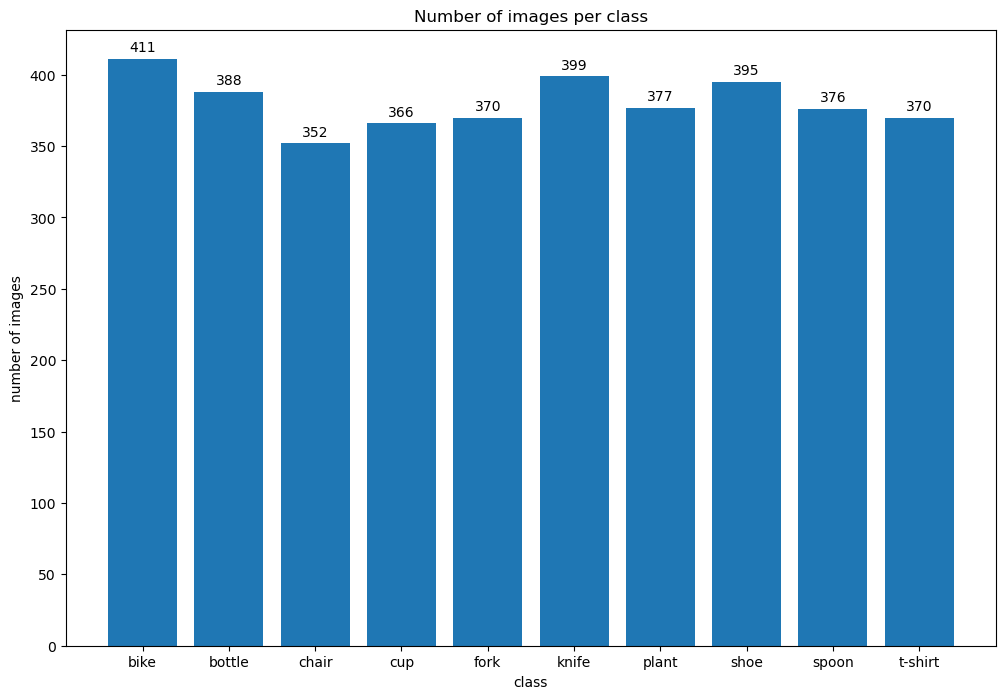

In [8]:
# Computing the image properties based on class and global properties(before normalization and data augmentation, 
# especially mean and standard deviation of the original data(without saving the images)

transformed_data_class1 = ImageTransformer(
    images_path=os.path.join(os.getcwd(),"..","data_copy"),
    fixed_size=(224,224))

batch_data_loader1 = DataLoader(transformed_data_class1, batch_size=32, shuffle=False, num_workers=0)

print ("Started loading images to compute image properties for original data")

# Mean and standard deviation are identified for normaliztion of the data
class_dict1,global_stats1 = compute_class_stats(batch_data_loader1, transformed_data_class1)
print("Completed computing image properties for original data.\n")

plot_number_of_images(class_dict1,save_title="Original_dataset_number_of_images_per_class")

In [15]:
# Normalizing the original data using the calculated mean and standard deviation and saving it in the new_data directory.
transformed_data_class2= ImageTransformer(
    images_path=os.path.join(os.getcwd(),"..","data_copy"),
    fixed_size=(224,224),
    save_dir=os.path.join(os.getcwd(),"..","new_data"),
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(global_stats1["mean"].tolist(), global_stats1["std"].tolist())]))

batch_data_loader2 = DataLoader(transformed_data_class2, batch_size=32, shuffle=False, num_workers=0)

print ("Started loading images to compute image properties for original data")

# Mean and standard deviation are identified for normaliztion of the data
class_dict2,global_stats2 = compute_class_stats(batch_data_loader2, transformed_data_class2)
print("Completed computing image properties for original data.\n")

Scanning through bike images.......
Scanning through bottle images.......
Scanning through chair images.......
Scanning through cup images.......
Scanning through fork images.......
Scanning through knife images.......
Scanning through plant images.......
Scanning through shoe images.......
Scanning through spoon images.......
Scanning through t-shirt images.......
Started loading images to compute image properties for original data


KeyboardInterrupt: 

In [14]:
# Performing the data augmentation operations(like cropping,flipping, rotating and change of colors) and
#normalizing augmented data with normalized mean and standard deviation of the original data
transforms3 = transforms.Compose([transforms.RandomResizedCrop(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  
    transforms.ToTensor(),
    transforms.Normalize(global_stats1["mean"].tolist(), global_stats1["std"].tolist())])

transformed_data_class3 = ImageTransformer(
    images_path=os.path.join(os.getcwd(),"..","data_copy"),
    fixed_size=(224,224),
    save_dir=os.path.join(os.getcwd(),"..","new_data"),
    transform=transforms3,
    augment_data=True)

batch_data_loader3 = DataLoader(transformed_data_class3, batch_size=32, shuffle=False, num_workers=0)

print ("Started loading images to compute image properties for transformed data")

# Computing the image properties(based on class and global properties) of augmented data after normalization and data augmentation using the mean and standard deviation of the data
class_dict3,global_stats3 = compute_class_stats(batch_data_loader3, transformed_data_class3)

print("Completed computing image properties for transformed data.\n")
print("Data augmentation Completed. The database has been augmented")
plot_number_of_images(class_dict3,save_title="Augmented_dataset_number_of_images_per_class")

Scanning through bike images.......
Scanning through bottle images.......
Scanning through chair images.......
Scanning through cup images.......
Scanning through fork images.......
Scanning through knife images.......
Scanning through plant images.......
Scanning through shoe images.......
Scanning through spoon images.......
Scanning through t-shirt images.......
Started loading images to compute image properties for transformed data 
Completed computing image properties for transformed data.

Data augmentation Completed. The database has been augmented


In [16]:
global_stats3

{'mean': tensor([-0.3293, -0.2855, -0.2123]),
 'std': tensor([1.1543, 1.1620, 1.0960]),
 'max': tensor([2.0630, 2.3247, 2.4956]),
 'min': tensor([-2.3127, -2.1900, -1.9414])}

In [17]:
len(transformed_data_class3)

7608

In [ ]:
def save_dataloader(dataloader,class_dict_stats,global_dict_stats,filename):
    """
    Function: Saves the DataLoader and its associated dataset with the current random state for reproducibility.

    Parameters:
        dataloader (torch.utils.data.DataLoader): The DataLoader to be saved.
        filename (str): The path to the file where the DataLoader will be saved.
    """
    # Saving random states for reproducibility
    random_state = random.getstate()
    np_state = np.random.get_state()
    torch_state = torch.random.get_rng_state()

    dataset = dataloader.dataset
    # Saving random states for reproducibility
    save_dict={
        "dataset":dataset,
        "class_dict_stats":class_dict_stats,
        "global_dict_stats":global_dict_stats,
        "random_state":random_state,
        "np_state":np_state,
        "torch_state":torch_state,
        "batch_size":dataloader.batch_size,
        "num_workers":dataloader.num_workers
    }
    with open(filename,"wb") as file:
        pickle.dump(save_dict,file)
    print(f"Dataloader and  random state save to {filename}")
save_dataloader(batch_data_loader3,class_dict3,global_stats3,"batch_data_loader3.pth")

Dataloader and  random state save to batch_data_loader3.pth


In [21]:
def load_dataloader(filename):
    """
    Function: Loads the saved DataLoader and restores the random states 

    Parameters:
        filename (str): The path to the file where the DataLoader was saved.

    Returns:
        DataLoader: The reloaded DataLoader.
    """
    # loading the saved dictionary
    with open(filename, 'rb') as f:
        saved_data = pickle.load(f)

    # loading dataset and random states
    loaded_dataset = saved_data['dataset']
    class_dict_stats = saved_data['class_dict_stats']
    global_dict_stats = saved_data['global_dict_stats']
    random_state = saved_data['random_state']
    np_state = saved_data['np_state']
    torch_state = saved_data['torch_state']
    
    # loading random states for reproducibility
    random.setstate(random_state)
    np.random.set_state(np_state)
    torch.random.set_rng_state(torch_state)

    # Recreating the DataLoader
    loaded_dataloader = DataLoader(
        loaded_dataset,
        batch_size=saved_data['batch_size'],
        num_workers=saved_data['num_workers'])

    print(f"DataLoader loaded from {filename}")
    return loaded_dataloader, class_dict_stats, global_dict_stats

# loading the stored batch laoder data
loaded_dataloader, class_dict_stats, global_dict_stats=load_dataloader("batch_data_loader3.pth")

DataLoader loaded from batch_data_loader3.pth


In [22]:
global_dict_stats

{'mean': tensor([-0.3293, -0.2855, -0.2123]),
 'std': tensor([1.1543, 1.1620, 1.0960]),
 'max': tensor([2.0630, 2.3247, 2.4956]),
 'min': tensor([-2.3127, -2.1900, -1.9414])}

## Visualizing the images

In [ ]:
def min_max_image(image):
    """
    Function: Coverting the pixel values of the image of range [0,255] to the range of [0,1]

    The minimum and maximum of the image generated are not with in the range of 0 and 1. 
    So we are reducing the pixels values to the range of [0,1]

    Parameters:
        image(np.array): A numpy array of the image with pixel values ranging from [0,255]
    Returns:
        (np.array): A numpy array of the image with pixel values ranging from [0,1]
    """
    return (image - image.min()) / (image.max() - image.min())


def visualize_batch(images, labels, class_names, min_max_image_func):
    """
    Function:
        To visualize batch of images along with their corresponding labels in a grid.

    Parameters:
        images(np.array): Batch of images, of the shape (batch_size,height,width,channels)
        labels(np.array): class indices of the images
        class_names(List[str]):Class names of the images
        min_max_image_func:A function that takes an image (numpy array) as input and returns
                            the normalized image (in the range [0, 1]). This is typically used to
                            scale pixel values before visualization.
     Returns:
        None: This function only handles visualization and does not return any values.
    Example use of the function:
        batch_images, class_indices = next(dataiter)
    
        # Converting the tensor to a numpy array and permute dimensions for matplotlib
        batch_images = batch_images.numpy()  # Convert to numpy array
        batch_images = batch_images.transpose(0, 2, 3, 1)  # Changing from (batch_size, channels, height, width) of Tensor to 
                                                            # (batch_size, height, width, channels) of numpy.

        class_names = transformed_data_class3.classes

        visualize_batch(batch_images, class_indices, class_names, min_max_image) 
    """
    # Calculating the grid size
    num_rows = int(np.ceil(np.sqrt(len(images)))) 

    # Plotting the images in a grid
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_rows,figsize=(10,10))
    for idx, axis in enumerate(axes.flatten()):
        if idx<len(images):
            # reducing the range of the image to [0,1]
            normalized_image=min_max_image(images[idx])
            axis.imshow(normalized_image)  # Visualizing the omage
            axis.set_title(class_names[labels[idx]])  # Setting the title to the class name
        axis.axis("off") 
    plt.tight_layout()
    plt.show()

In [24]:
# Fixing the iteration of batches
dataiter=iter(batch_data_loader3)

Here are the batch of images. Please run the cell to visualize the next batch


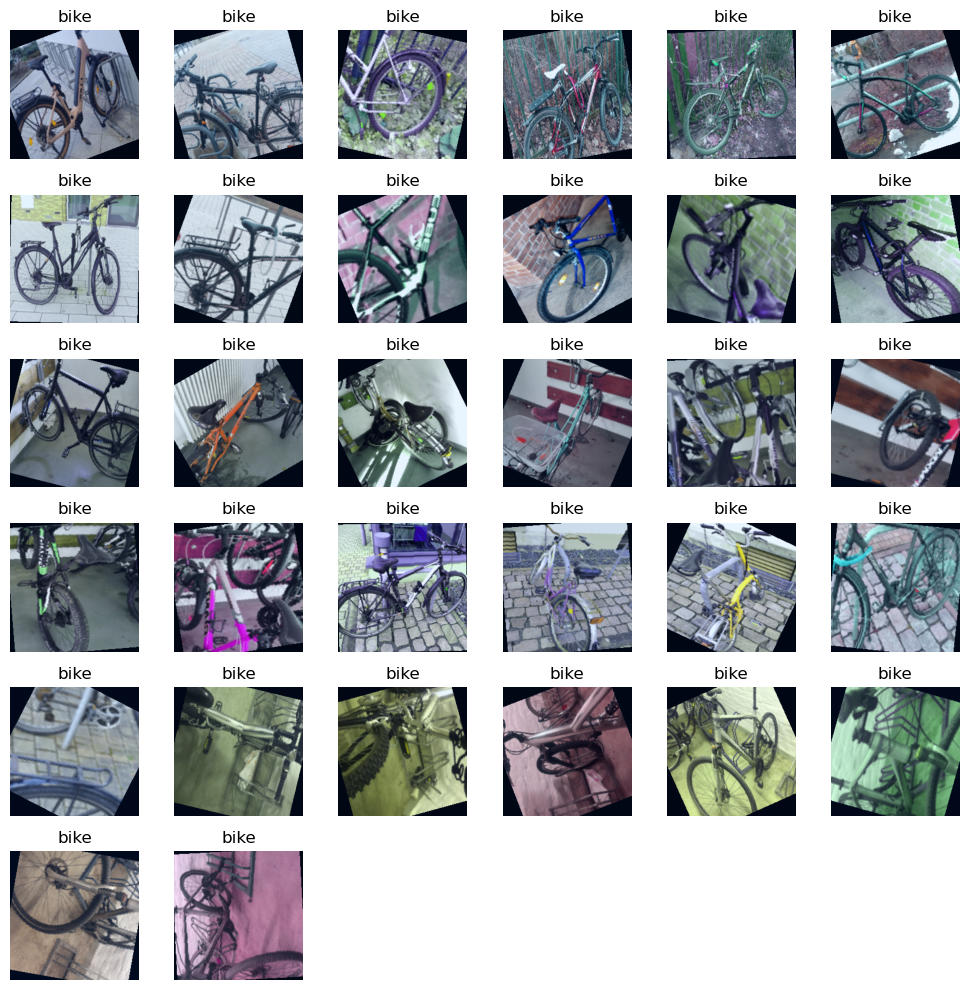

In [ ]:
# rolling through each batch and visualizing the batch images
batch_images, class_indices = next(dataiter)
 
# Converting the tensor to a numpy array and permute dimensions for matplotlib
batch_images = batch_images.numpy()  # Convert to numpy array
batch_images = batch_images.transpose(0, 2, 3, 1)  # Changing from (batch_size, channels, height, width) of Tensor to 
                                                    # (batch_size, height, width, channels) of numpy.

class_names = transformed_data_class3.classes

print("Here are the batch of images. Please run the cell to visualize the next batch")

visualize_batch(batch_images, class_indices, class_names, min_max_image)